In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
    !tar xf spark-3.3.2-bin-hadoop3.tgz
    !mv spark-3.3.2-bin-hadoop3 spark
    !pip install -q findspark
    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark"

In [ ]:
import pandas as pd

import findspark
findspark.init()
spark_url = 'local'
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import split, col
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import numpy as np


In [3]:
num_cores = 8
spark = SparkSession.builder\
        .master(spark_url)\
        .appName('Spark Data Prep')\
        .config('spark.ui.port', '4040')\
        .config("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true") \
        .config("spark.driver.memory", "16g") \
        .config("spark.executor.memory", "16g") \
        .config("spark.default.parallelism", str(num_cores)) \
        .config("spark.sql.shuffle.partitions", str(num_cores)) \
        .getOrCreate()
sc = spark.sparkContext
path = 'bangkok_traffy.csv'

In [4]:
df = spark.read.option("multiline", "true") \
               .option("quote", "\"") \
               .option("escape", "\"") \
               .csv(path, header=True, inferSchema=True)

# Data preprocessing

In [5]:
df = df.dropDuplicates()

In [6]:
df = df.dropna(subset=['ticket_id', 'organization','timestamp','last_activity','state','coords', 'type'], how='any')

## preprocessing state and completion time calculation

In [7]:
df = df.filter(col('state')=="เสร็จสิ้น")

In [8]:
df = df.withColumn('completion_time_hours', 
                   (F.unix_timestamp('last_activity') - F.unix_timestamp('timestamp')) / 3600)

## preprocessing coordinations

In [9]:
# Split the 'coords' column into two new columns 'latitude' and 'longitude'
df = df.withColumn('longitude', split(df['coords'], ',').getItem(0).cast('double')) \
       .withColumn('latitude', split(df['coords'], ',').getItem(1).cast('double'))


## deal with out of range coordination (outlier)

In [10]:
# Define the latitude and longitude bounds mainly in กรุงเทพ
latitude_min = 13.4
latitude_max = 14.3
longitude_min = 99.8
longitude_max = 101

# keep only the rows within the defined bounds
df = df.filter(
    (df['latitude'] >= latitude_min) & (df['latitude'] <= latitude_max) &
    (df['longitude'] >= longitude_min) & (df['longitude'] <= longitude_max))

## preprocessing province

In [11]:
# keep only rows that province are กรุงเทพ และ ปริมณฑล
pattern = "(?i)กรุงเทพ|Bangkok|นนทบุรี|นครปฐม|ปทุมธานี|สมุทรปราการ|สมุทรสาคร"
df = df.filter(col("province").isNotNull() & col("province").rlike(pattern))

In [12]:
# Apply pattern matching and replace values
df = df.withColumn(
    "province",
    F.when(
        F.col("province").rlike("(?i).*กรุงเทพ.*|.*Bangkok.*"), "กรุงเทพมหานคร"
    )
    .when(F.col("province").rlike("(?i).*นนทบุรี.*"), "นนทบุรี")
    .when(F.col("province").rlike("(?i).*สมุทรปราการ.*"), "สมุทรปราการ")
    .when(F.col("province").rlike("(?i).*ปทุมธานี.*"), "ปทุมธานี")
    .when(F.col("province").rlike("(?i).*สมุทรสาคร.*"), "สมุทรสาคร")
    .when(F.col("province").rlike("(?i).*นครปฐม.*"), "นครปฐม")
    .otherwise(F.col("province"))
)


## preprocessing type

In [13]:
# remove rows with empty type
df = df.filter(df['type'] != '{}')
# Remove '{' and '}' and split the 'type' column by ','
df = df.withColumn('type_array', F.split(F.regexp_replace(df['type'], '[\{\}]', ''), ','))
# type_array is for visualization

In [14]:
# onehot for types

df_type = df.withColumn("type", F.explode("type_array"))

# replace commas, spaces, symbols with _ to avoid INVALID_ATTRIBUTE_NAME_SYNTAX column name error
df_type = df_type.withColumn(
    "type_clean",
    F.regexp_replace(
        "type",
        r"[^0-9A-Za-zก-๙_]",   # allow digits, A-Z, a-z, Thai, underscore
        "_"
    )
)

# add prefix BEFORE pivot
df_type = df_type.withColumn(
    "type_pivot_key",
    F.concat(F.lit("type_"), F.col("type_clean"))
)

# pivot type to columns
type_wide = (
    df_type
    .select("ticket_id", "type_pivot_key")
    .withColumn("value", F.lit(1.0))
    .groupBy("ticket_id")
    .pivot("type_pivot_key")
    .agg(F.first("value"))
)
# list of type columns
type_cols = [c for c in type_wide.columns if c != "ticket_id"]

# for type that the ticket is not, fill with 0
type_wide = type_wide.fillna(0.0, subset=type_cols)


## preprocessing organization

In [15]:
# 'organization' to array
df = df.withColumn('organization_array', split(F.regexp_replace(F.col('organization'), '\\s*,\\s*', ','), ','))

In [16]:
# remove organization from the array that look like person names in parentheses, e.g. "... (นาง...)"/"... (นาย...)"
person_pattern = r'\( *?(นาย|นาง|น\.ส\.|นางสาว)[^\)]*\)'

# trim items, remove empties and remove items matching the person pattern
df = df.withColumn(
    "organization_array",
    F.filter(
        F.transform(F.col("organization_array"), lambda x: F.trim(x)),
        lambda x: (x != "") & (~F.lower(x).rlike(person_pattern))
    )
)

In [17]:
pathOrgsLoc = 'org_with_loc_v2.csv'
dfOrg = spark.read.csv(pathOrgsLoc, header=True, inferSchema=True)
dfOrg.printSchema()

# prepare org location dictionary for fast lookup
org_loc = {row['organization_raw']: (row['latitude'], row['longitude']) for row in dfOrg.collect()}

root
 |-- organization_raw: string (nullable = true)
 |-- displayName: string (nullable = true)
 |-- formattedAddress: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



In [18]:
from pyspark.sql.types import ArrayType, StringType
# only keep organizations that have valid locations in the org_loc dictionary
def filter_orgs(orgs):
    filtered = []
    if orgs is None:
        return filtered
    for org in orgs:
        loc = org_loc.get(org)
        if loc and loc[0] != "Not Found" and loc[1] != "Not Found":
            filtered.append(org)
    return filtered

filter_orgs_udf = F.udf(filter_orgs, ArrayType(StringType()))

# apply filter to the array
df = df.withColumn('organization_array', filter_orgs_udf(col('organization_array')))

## calculate orgs distance

In [19]:
from pyspark.sql.types import ArrayType, DoubleType, StructField, StructType
import math
from pyspark.sql.functions import udf, col

# calculate haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(float, [lat1, lon1, lat2, lon2])
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))


def calc_distances(orgs, lat, lon):
    if orgs is None or lat is None or lon is None:
        return []
    distances = list()
    for org in orgs:
        loc = org_loc.get(org)
        if loc and loc[0] != "Not Found" and loc[1] != "Not Found":
            try:
                dist = haversine(lat, lon, float(loc[0]), float(loc[1]))
                distances.append(dist)
            except Exception:
                continue
    return distances

def calc_distance_with_coords(org, lat, lon):
    if org is None or lat is None or lon is None:
        return (None, None, None)  # distance, org_lat, org_lon
    
    loc = org_loc.get(org)
    if not loc or loc[0] == "Not Found" or loc[1] == "Not Found":
        return (None, None, None)
    
    try:
        org_lat = float(loc[0])
        org_lon = float(loc[1])
        distance = haversine(lat, lon, org_lat, org_lon)
        return (distance, org_lat, org_lon)
    except Exception:
        return (None, None, None)


schema = StructType([
    StructField("distance_km", DoubleType(), True),
    StructField("organization_latitude", DoubleType(), True),
    StructField("organization_longitude", DoubleType(), True)
])


calc_distance_udf = udf(calc_distance_with_coords, schema)


In [20]:
# calculate distances into array
# this is for visualization
df = (df
    .withColumn("organization", F.explode("organization_array"))
    .withColumn(
        "org_info",
        calc_distance_udf(
            F.col("organization"),
            F.col("latitude"),
            F.col("longitude")
        )
    ))

df = (
    df
    .withColumn("organization_distance", F.col("org_info.distance_km"))
    .withColumn("organization_latitude", F.col("org_info.organization_latitude"))
    .withColumn("organization_longitude", F.col("org_info.organization_longitude"))
    .drop("org_info", "organization_array", "type")
)

# df = df.withColumn(
#     'organization_distances',
#     calc_distances_udf(col('organization_array'), col('latitude'), col('longitude'))
# )

In [21]:
df = df.drop("organization_array", "type")

In [22]:
df.columns

['ticket_id',
 'organization',
 'comment',
 'photo',
 'photo_after',
 'coords',
 'address',
 'subdistrict',
 'district',
 'province',
 'timestamp',
 'state',
 'star',
 'count_reopen',
 'last_activity',
 'completion_time_hours',
 'longitude',
 'latitude',
 'type_array',
 'organization_distance',
 'organization_latitude',
 'organization_longitude']

In [23]:
# onehot for organization and its distance to the ticket

ticket_org = (
    df
    .filter(F.col("organization_distance").isNotNull())
    .select("ticket_id", "organization", "organization_distance")
)

# ticket_org.show(2, truncate=False)
# replace commas, spaces, symbols with _ to avoid INVALID_ATTRIBUTE_NAME_SYNTAX column name error
ticket_org = ticket_org.withColumn(
    "organization_clean",
    F.regexp_replace(
        "organization",
        r"[^0-9A-Za-zก-๙_]",
        "_"
    )
)

# add prefix BEFORE pivot
ticket_org = ticket_org.withColumn(
    "org_pivot_key",
    F.concat(F.lit("dist_"), F.col("organization_clean"))
)

# pivot organization to columns
org_wide = (
    ticket_org
    .select("ticket_id", "org_pivot_key", "organization_distance")
    .groupBy("ticket_id")
    .pivot("org_pivot_key")
    .agg(F.first("organization_distance"))
)

# list of organization columns
org_cols = [c for c in org_wide.columns if c != "ticket_id"]

# if organization is not responsible for the ticket, fill -1
org_wide = org_wide.fillna(-1.0, subset=org_cols)


# Final data

In [24]:
# pick necessary column for AIML
ticket_base = (
    df
    .select("ticket_id", "latitude", "longitude", "completion_time_hours")
    .dropDuplicates(["ticket_id"])
)

# org and type onehot
features = (
    ticket_base
    .join(org_wide, on="ticket_id", how="left")
    .join(type_wide, on="ticket_id", how="left")
)


In [25]:
# this data is for training AI
features_ml = features.drop("ticket_id")
viz_data = df

# examine data and export

In [28]:
viz_data.printSchema()

root
 |-- ticket_id: string (nullable = true)
 |-- organization: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- photo: string (nullable = true)
 |-- photo_after: string (nullable = true)
 |-- coords: string (nullable = true)
 |-- address: string (nullable = true)
 |-- subdistrict: string (nullable = true)
 |-- district: string (nullable = true)
 |-- province: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- star: integer (nullable = true)
 |-- count_reopen: integer (nullable = true)
 |-- last_activity: timestamp (nullable = true)
 |-- completion_time_hours: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- type_array: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- organization_distance: double (nullable = true)
 |-- organization_latitude: double (nullable = true)
 |-- organization_longitude: double (nullable = tr

In [29]:
print(len(features_ml.columns))
print(features_ml.columns)

1609
['latitude', 'longitude', 'completion_time_hours', 'dist_1111_ศูนย์รับเรื่องราวร้องทุกข์ของรัฐบาล', 'dist_BTS', 'dist_Bangkok_Smart_Lighting', 'dist_Bangkok_Smart_Lighting__สำนักการโยธา_กทม__', 'dist_CAT_TELECOM__Official_', 'dist_CU_iHouse___CU_Terrace', 'dist_Chula_TUN_JAI_สำนักงานจัดการทรัพย์สิน', 'dist_Chula_TUN_JAI_สำนักบริหารระบบกายภาพ', 'dist_Komgrip', 'dist_MEA', 'dist_MEA_บางขุนเทียน_บำรุงรักษาเสาสาย', 'dist_MEA_บางขุนเทียน_หม้อแปลงฯ', 'dist_MEA_บางขุนเทียน_แก้ไฟฟ้าขัดข้อง', 'dist_MEA_บางขุนเทียน_ไฟฟ้าสาธารณะ', 'dist_MRTA', 'dist_NECTEC', 'dist_NT_ฝ่ายธุรกิจบริการดิจิทัล_ส่วนพันธมิตรบริการดิจิทัล', 'dist_PTT_HO', 'dist_SCGC', 'dist_TOT_smartcity', 'dist_The_line_Jatujak_Mochit__นิติ_', 'dist__ติดตามคำขออนุญาต__ทีมงานผู้ว่าราชการกรุงเทพมหานคร', 'dist_iACO_Bangkokเครือข่ายปปช_ภาคประชาสังคม', 'dist_กกจ_1_ฝกจ_1', 'dist_กกจ_2_ฝกจ_1', 'dist_กกจ_3_ฝกจ_1', 'dist_กกจ_4_ฝกจ_1', 'dist_กกต', 'dist_กทม', 'dist_กผ3_สวจ__สจส__กทม_', 'dist_กฟน_', 'dist_กรมการขนส่งทางบก', 'dist_กรมการขนส่

In [45]:
features_ml.select("completion_time_hours").describe().show()
quantiles = features_ml.approxQuantile(
    "completion_time_hours",
    probabilities=[0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    relativeError=0.01
)

print("Quantiles:")
print("min = ", quantiles[0])
print("10% =", quantiles[1])
print("25% =", quantiles[2])
print("50% =", quantiles[3])
print("75% =", quantiles[4])
print("90% =", quantiles[5])
print("max =",  quantiles[6])

features_ml.select("completion_time_hours").rdd.flatMap(lambda x: x).histogram(10)

+-------+---------------------+
|summary|completion_time_hours|
+-------+---------------------+
|  count|               544599|
|   mean|    1612.202140065448|
| stddev|    3121.189844911014|
|    min| 0.006111111111111111|
|    max|    25765.44638888889|
+-------+---------------------+

Quantiles:
min =  0.006111111111111111
10% = 15.692777777777778
25% = 43.93277777777778
50% = 186.6197222222222
75% = 1396.5925
90% = 5327.8469444444445
max = 25765.44638888889


([0.006111111111111111,
  2576.5501388888893,
  5153.094166666667,
  7729.638194444445,
  10306.182222222224,
  12882.726250000002,
  15459.27027777778,
  18035.814305555556,
  20612.358333333334,
  23188.90236111111,
  25765.44638888889],
 [442170, 42212, 25486, 17128, 8410, 4673, 2733, 1060, 723, 4])

<h1> stratification </h1>

In [50]:
from pyspark.sql import Window

# 1. Create 10 bins based on completion_time_hours (approx quantiles)
w = Window.orderBy("completion_time_hours")

features_binned = (
    features_ml
    .withColumn("time_bin", F.ntile(10).over(w))     # 10 bins: 1..10
    .withColumn("row_id", F.monotonically_increasing_id())  # unique ID
    .cache()
)


# 2. For each bin, we want 20% of rows in test set
fractions = (
    features_binned
    .select("time_bin")
    .distinct()
    .withColumn("fraction", F.lit(0.2))    # 20% per bin for test set
    .rdd
    .map(lambda row: (row["time_bin"], row["fraction"]))
    .collectAsMap()
)

print(fractions)  # just to inspect, should be {1: 0.2, 2: 0.2, ..., 10: 0.2}


# 3. Sample test_data stratified by time_bin
test_data = features_binned.stat.sampleBy(
    "time_bin",
    fractions,
    seed=1234
)

# 4) Get only the IDs for test_data
test_ids = test_data.select("row_id")

# 5) Train = all rows whose row_id is NOT in test_ids
train_data = features_binned.join(test_ids, on="row_id", how="left_anti")

train_data = train_data.drop("time_bin", "row_id")
test_data  = test_data.drop("time_bin", "row_id")

{1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2, 5: 0.2, 6: 0.2, 7: 0.2, 8: 0.2, 9: 0.2, 10: 0.2}


In [51]:
test_data.select("completion_time_hours").describe().show()
quantiles = test_data.approxQuantile(
    "completion_time_hours",
    probabilities=[0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    relativeError=0.01
)

print("Quantiles:")
print("min = ", quantiles[0])
print("10% =", quantiles[1])
print("25% =", quantiles[2])
print("50% =", quantiles[3])
print("75% =", quantiles[4])
print("90% =", quantiles[5])
print("max =",  quantiles[6])

test_data.select("completion_time_hours").rdd.flatMap(lambda x: x).histogram(10)

+-------+---------------------+
|summary|completion_time_hours|
+-------+---------------------+
|  count|               109113|
|   mean|    1606.712115923137|
| stddev|   3120.1955987584147|
|    min| 0.015277777777777777|
|    max|           23303.6875|
+-------+---------------------+



Quantiles:
min =  0.015277777777777777
10% = 16.01638888888889
25% = 44.091944444444444
50% = 185.74138888888888
75% = 1324.9352777777779
90% = 5205.285
max = 23303.6875


([0.015277777777777777,
  2330.3824999999997,
  4660.749722222222,
  6991.116944444444,
  9321.484166666667,
  11651.85138888889,
  13982.218611111111,
  16312.585833333333,
  18642.953055555554,
  20973.320277777777,
  23303.6875],
 [87468, 8198, 5467, 3230, 2273, 1098, 710, 361, 191, 117])

In [60]:
train_data.select("completion_time_hours").describe().show()
quantiles = train_data.approxQuantile(
    "completion_time_hours",
    probabilities=[0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    relativeError=0.01
)

print("Quantiles:")
print("min = ", quantiles[0])
print("10% =", quantiles[1])
print("25% =", quantiles[2])
print("50% =", quantiles[3])
print("75% =", quantiles[4])
print("90% =", quantiles[5])
print("max =",  quantiles[6])

train_data.select("completion_time_hours").rdd.flatMap(lambda x: x).histogram(10)

+-------+---------------------+
|summary|completion_time_hours|
+-------+---------------------+
|  count|               435486|
|   mean|   1613.5776906095211|
| stddev|    3121.440977020044|
|    min| 0.006111111111111111|
|    max|    25765.44638888889|
+-------+---------------------+

Quantiles:
min =  0.006111111111111111
10% = 16.90222222222222
25% = 43.628055555555555
50% = 186.99722222222223
75% = 1351.1236111111111
90% = 5228.1175
max = 25765.44638888889


([0.006111111111111111,
  2576.5501388888893,
  5153.094166666667,
  7729.638194444445,
  10306.182222222224,
  12882.726250000002,
  15459.27027777778,
  18035.814305555556,
  20612.358333333334,
  23188.90236111111,
  25765.44638888889],
 [353520, 33790, 20424, 13654, 6745, 3742, 2195, 841, 572, 3])

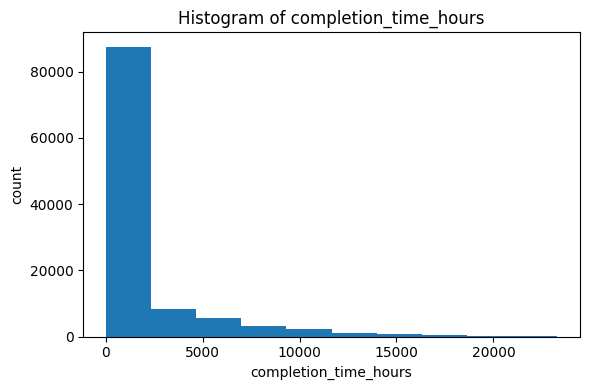

In [ ]:
bins, counts = (
    test_data
        .select("completion_time_hours")
        .rdd.flatMap(lambda x: x)
        .histogram(10)
)

plt.figure(figsize=(6,4))

# use bins[:-1] as bar start positions, np.diff(bins) as bar widths
plt.bar(bins[:-1], counts, width=np.diff(bins), align="edge")

plt.xlabel("completion_time_hours")
plt.ylabel("count")
plt.title("Histogram of completion_time_hours")

plt.tight_layout()
plt.show()


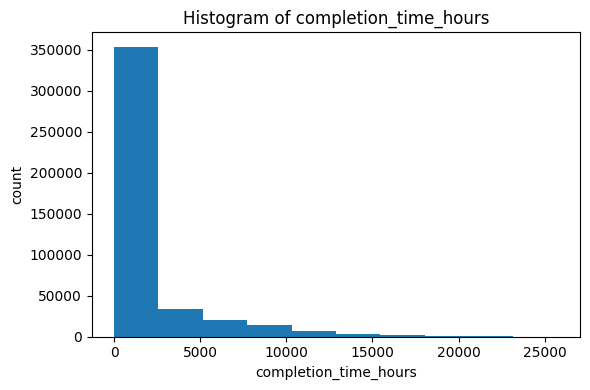

In [ ]:
bins, counts = (
    train_data
        .select("completion_time_hours")
        .rdd.flatMap(lambda x: x)
        .histogram(10)
)

plt.figure(figsize=(6,4))

# use bins[:-1] as bar start positions, np.diff(bins) as bar widths
plt.bar(bins[:-1], counts, width=np.diff(bins), align="edge")

plt.xlabel("completion_time_hours")
plt.ylabel("count")
plt.title("Histogram of completion_time_hours")

plt.tight_layout()
plt.show()


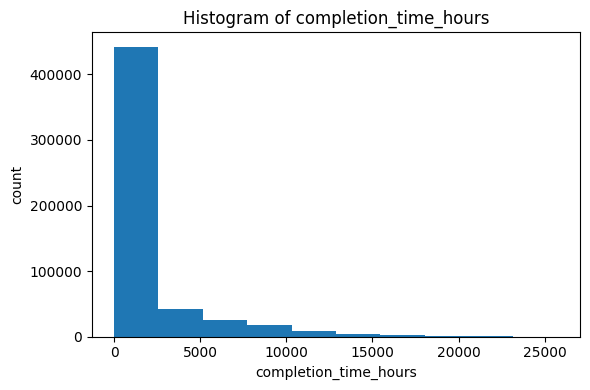

In [ ]:
bins, counts = (
    features_ml
        .select("completion_time_hours")
        .rdd.flatMap(lambda x: x)
        .histogram(10)
)

plt.figure(figsize=(6,4))

# use bins[:-1] as bar start positions, np.diff(bins) as bar widths
plt.bar(bins[:-1], counts, width=np.diff(bins), align="edge")

plt.xlabel("completion_time_hours")
plt.ylabel("count")
plt.title("Histogram of completion_time_hours")

plt.tight_layout()
plt.show()


<h1>export</h1>

In [57]:
path_to_your_folder = "C:/Users/Noon/Documents/DSDE/projectTraffy/1"
test_path = f"{path_to_your_folder}/test_data"
train_path = f"{path_to_your_folder}/train_data"
viz_path = f"{path_to_your_folder}/cleaned_Viz_data"
data_ml_path = f"{path_to_your_folder}/cleaned_ml_data"

In [ ]:
n_partitions = 10

In [58]:
train_data.repartition(n_partitions).write.mode("overwrite").option("header", "true").csv(train_path)

In [59]:
test_data.repartition(n_partitions).write.mode("overwrite").option("header", "true").csv(test_path)

In [38]:
viz_data.coalesce(1).write.mode("overwrite").json(viz_path)

In [39]:
features_ml.repartition(n_partitions).write.mode("overwrite").option("header", "true").csv(data_ml_path)